In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime
 
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./egyesitett_jo.csv")
data["Date"] = pd.to_datetime(data["Date"])
data

,Date,Close,Volume,Open,High,Low,Name
0,2023-10-19,128.40,60961360,130.57,132.24,127.47,AMZN
1,2023-10-18,128.13,42699480,129.90,130.67,127.51,AMZN
2,2023-10-17,131.47,49344550,130.39,132.58,128.71,AMZN
3,2023-10-16,132.55,42832920,130.69,133.07,130.43,AMZN
4,2023-10-13,129.79,45824690,132.98,133.31,128.95,AMZN
...,...,...,...,...,...,...,...
12580,2013-10-25,11.31,113661738,11.61,11.63,11.12,TSLA
12581,2013-10-24,11.54,161740419,11.00,11.63,10.86,TSLA
12582,2013-10-23,10.97,199788950,11.26,11.45,10.68,TSLA
12583,2013-10-22,11.44,170788865,11.37,11.85,11.07,TSLA


# Adatfelderítés

In [22]:
data.isna().sum()

Date      0
Close     0
Volume    0
Open      0
High      0
Low       0
Name      0
dtype: int64

In [12]:
data["Name"].unique()

array(['AMZN', 'AAPL', 'MSFT', 'SBUX', 'TSLA'], dtype=object)

In [13]:
amazon = data[data["Name"] == "AMZN"].sort_values(by = "Date")
apple = data[data["Name"] == "AAPL"].sort_values(by = "Date")
microsoft = data[data["Name"] == "MSFT"].sort_values(by = "Date")
starbucks = data[data["Name"] == "SBUX"].sort_values(by = "Date")
tesla = data[data["Name"] == "TSLA"].sort_values(by = "Date")

In [14]:
amazon.describe()

,Date,Close,Volume,Open,High,Low
count,2517,2517.000000,2.517000e+03,2517.000000,2517.000000,2517.000000
mean,2018-10-20 04:16:52.634088192,81.952777,8.018249e+07,81.987060,82.939444,80.938776
min,2013-10-21 00:00:00,14.350000,1.762674e+07,14.220000,14.520000,14.200000
25%,2016-04-21 00:00:00,33.700000,5.402790e+07,33.710000,34.020000,33.230000
50%,2018-10-18 00:00:00,84.470000,6.892762e+07,84.560000,85.390000,83.330000
75%,2021-04-21 00:00:00,122.350000,9.279190e+07,122.400000,123.850000,120.630000
max,2023-10-19 00:00:00,186.570000,4.769344e+08,187.200000,188.650000,184.840000
std,NaN,51.493662,4.144481e+07,51.541672,52.181455,50.837581


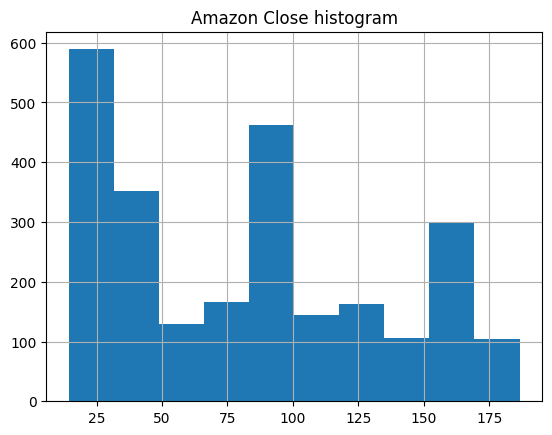

In [23]:
amazon["Close"].hist()
plt.title("Amazon Close histogram")
plt.show()

# DTW előtti skálázás

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))


amazon_scaled = amazon.copy()
apple_scaled = apple.copy()
microsoft_scaled = microsoft.copy()
starbucks_scaled = starbucks.copy()
tesla_scaled = tesla.copy()


amazon_scaled[["Close", "Volume", "Open", "High", "Low"]] = scaler.fit_transform(amazon_scaled[["Close", "Volume", "Open", "High", "Low"]])
apple_scaled[["Close", "Volume", "Open", "High", "Low"]] = scaler.fit_transform(apple_scaled[["Close", "Volume", "Open", "High", "Low"]])
microsoft_scaled[["Close", "Volume", "Open", "High", "Low"]] = scaler.fit_transform(microsoft_scaled[["Close", "Volume", "Open", "High", "Low"]])
starbucks_scaled[["Close", "Volume", "Open", "High", "Low"]] = scaler.fit_transform(starbucks_scaled[["Close", "Volume", "Open", "High", "Low"]])
tesla_scaled[["Close", "Volume", "Open", "High", "Low"]] = scaler.fit_transform(tesla_scaled[["Close", "Volume", "Open", "High", "Low"]])


tesla_scaled

,Date,Close,Volume,Open,High,Low,Name
12584,2013-10-21,0.008658,0.179434,0.010557,0.009968,0.009198,TSLA
12583,2013-10-22,0.008484,0.177253,0.008451,0.009032,0.008368,TSLA
12582,2013-10-23,0.007315,0.209353,0.008178,0.008048,0.007388,TSLA
12581,2013-10-24,0.008733,0.167237,0.007534,0.008491,0.007841,TSLA
12580,2013-10-25,0.008160,0.114019,0.009046,0.008491,0.008494,TSLA
...,...,...,...,...,...,...,...
10072,2023-10-13,0.604792,0.101439,0.621893,0.618773,0.609353,TSLA
10071,2023-10-16,0.611758,0.086629,0.599960,0.608437,0.604981,TSLA
10070,2023-10-17,0.614072,0.091771,0.600084,0.612817,0.601463,TSLA
10069,2023-10-18,0.583794,0.126733,0.606528,0.606542,0.588898,TSLA


In [6]:
len(tesla), len(apple), len(microsoft), len(amazon), len(starbucks)

(2517, 2517, 2517, 2517, 2517)

# DTW

In [7]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


dataframes = [amazon_scaled, apple_scaled, microsoft_scaled, starbucks_scaled, tesla_scaled]
names = ["amazon", "apple", "microsoft", "starbucks", "tesla"]


distance_matrix = np.zeros((5, 5))



for i in range(5):
    for j in range(5):
        if i != j:
            ts1 = dataframes[i]["Close"].values
            ts2 = dataframes[j]["Close"].values
            dtw_distance, path = fastdtw(ts1, ts2)
            distance_matrix[i][j] = dtw_distance

distance_matrix
dtw_df = pd.DataFrame(distance_matrix, index = names, columns = names)
dtw_df

,amazon,apple,microsoft,starbucks,tesla
amazon,0.000000,92.364839,67.203274,69.207481,52.047023
apple,92.364839,0.000000,31.196115,105.477447,107.381040
microsoft,67.203274,31.196115,0.000000,88.979514,86.311578
starbucks,69.207481,105.477447,88.979514,0.000000,71.706277
tesla,52.047023,107.381040,86.311578,71.706277,0.000000


# Cross-correlation

In [8]:
dataframes = [amazon_scaled, apple_scaled, microsoft_scaled, starbucks_scaled, tesla_scaled]
names = ["amazon", "apple", "microsoft", "starbucks", "tesla"]


distance_matrix = np.zeros((5, 5))



for i in range(5):
    for j in range(5):
        if i != j:
            ts1 = dataframes[i]["Close"].values
            ts2 = dataframes[j]["Close"].values
            dtw_distance = np.correlate(ts1, ts2)
            distance_matrix[i][j] = dtw_distance

distance_matrix
dtw_df = pd.DataFrame(distance_matrix, index = names, columns = names)
dtw_df

,amazon,apple,microsoft,starbucks,tesla
amazon,0.000000,510.673591,537.622245,570.377935,363.121491
apple,510.673591,0.000000,497.814135,493.649374,356.542169
microsoft,537.622245,497.814135,0.000000,518.194342,358.412728
starbucks,570.377935,493.649374,518.194342,0.000000,342.071585
tesla,363.121491,356.542169,358.412728,342.071585,0.000000


# Plotting the ones with the lowest dtw costs

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

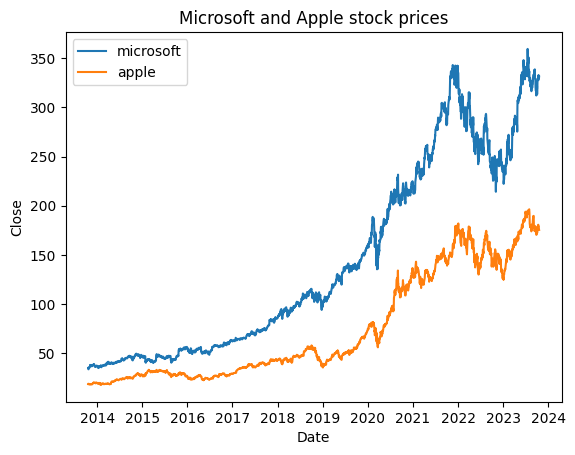

In [9]:
plt.plot(data[data["Name"] == "MSFT"]["Date"], data[data["Name"] == "MSFT"]["Close"], label = "microsoft")
plt.plot(data[data["Name"] == "AAPL"]["Date"], data[data["Name"] == "AAPL"]["Close"], label = "apple")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Microsoft and Apple stock prices")

plt.legend()
plt.show()

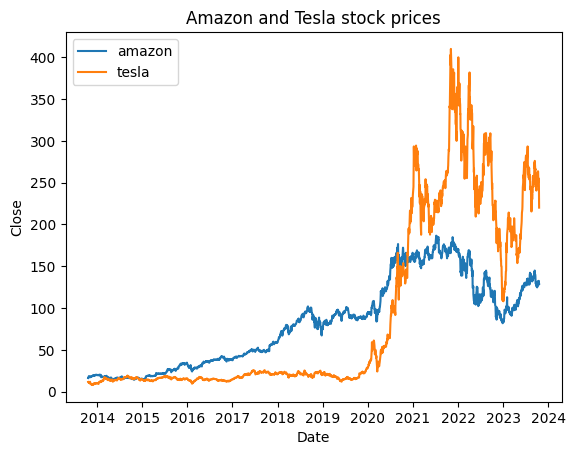

In [10]:
plt.plot(data[data["Name"] == "AMZN"]["Date"], data[data["Name"] == "AMZN"]["Close"], label = "amazon")
plt.plot(data[data["Name"] == "TSLA"]["Date"], data[data["Name"] == "TSLA"]["Close"], label = "tesla")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Amazon and Tesla stock prices")

plt.legend()
plt.show()

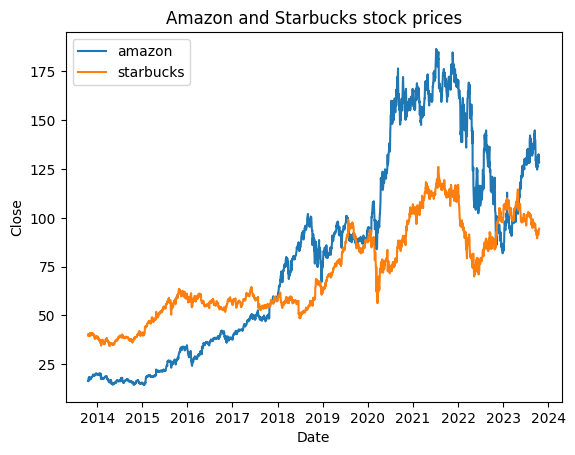

In [11]:
plt.plot(data[data["Name"] == "AMZN"]["Date"], data[data["Name"] == "AMZN"]["Close"], label = "amazon")
plt.plot(data[data["Name"] == "SBUX"]["Date"], data[data["Name"] == "SBUX"]["Close"], label = "starbucks")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Amazon and Starbucks stock prices")

plt.legend()
plt.show()